# Algorithms

In [1]:
import inspect
import matplotlib.pyplot as plt
import torch
from pytomography.io.SPECT import simind, dicom
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.algorithms import OSEM, OSMAPOSL, BSREM, KEM
import matplotlib.pyplot as plt
import torch
from pytomography.priors import RelativeDifferencePrior
from pytomography.priors import TopNAnatomyNeighbourWeight
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import KEMTransform
from pytomography.projectors.shared import KEMSystemMatrix
import os

In [2]:
# CHANGE THIS TO WHERE YOU DOWNLOADED THE TUTORIAL DATA
PATH = '/mnt/mydisk2/pytomo_tutorial_data/SPECT'

The code below is a summary of the SIMIND/DICOM introduciton tutorials. You can select whether or not to explore the SIMIND/DICOM data here

* This demonstrates what kind of code is reusable whether or not you're reconstructing SIMIND or DICOM data

In [3]:
TYPE = 'DICOM' # DICOM or SIMIND

In [4]:
if TYPE=='SIMIND':
    data_path = os.path.join(PATH, 'SIMIND-Jaszak', 'lu177_SYME_jaszak')
    IDX_AXIAL = 64 # for plotting
    photopeak_path = os.path.join(data_path,'tot_w4.h00')
    lower_path = os.path.join(data_path, 'tot_w5.h00')
    upper_path = os.path.join(data_path, 'tot_w6.h00')
    path_amap = os.path.join(data_path,'amap.hct')
    object_meta, proj_meta = simind.get_metadata(photopeak_path)
    photopeak = simind.get_projections(photopeak_path)
    activity = 1000 # MBq 
    time_per_proj = 15 # s
    photopeak = torch.poisson(photopeak * activity * time_per_proj)
    lower = simind.get_projections(lower_path)
    upper = simind.get_projections(upper_path)
    lower_realization = torch.poisson(lower * activity * time_per_proj)
    upper_realization = torch.poisson(upper * activity * time_per_proj)
    ww_peak, ww_lower, ww_upper = [simind.get_energy_window_width(path) for path in [photopeak_path, lower_path, upper_path]]
    scatter = simind.compute_EW_scatter(lower_realization, upper_realization , ww_lower, ww_upper, ww_peak)
    amap = simind.get_attenuation_map(path_amap)
    psf_meta = simind.get_psfmeta_from_header(photopeak_path)
    att_transform = SPECTAttenuationTransform(amap)
    psf_transform = SPECTPSFTransform(psf_meta)
elif TYPE=='DICOM':
    data_path = os.path.join(PATH, 'Lu177-NEMA-SymT2')
    IDX_AXIAL = 61 # for plotting
    path_CT = os.path.join(data_path, 'CT')
    files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
    file_NM = os.path.join(data_path, 'projection_data.dcm')
    object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=0)
    photopeak = dicom.get_projections(file_NM, index_peak=0)
    scatter = dicom.get_energy_window_scatter_estimate(file_NM, index_peak=0, index_lower=1, index_upper=2)
    att_transform = SPECTAttenuationTransform(filepath=files_CT)
    att_transform.configure(object_meta, proj_meta)
    amap = att_transform.attenuation_map
    collimator_name = 'SY-ME'
    energy_kev = 208 #keV
    intrinsic_resolution=0.38 #mm
    psf_meta = dicom.get_psfmeta_from_scanner_params(
        collimator_name,
        energy_kev,
        intrinsic_resolution=intrinsic_resolution
    )
    psf_transform = SPECTPSFTransform(psf_meta)
    
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta
)
likelihood = PoissonLogLikelihood(
    system_matrix = system_matrix,
    projections = photopeak,
    additive_term = scatter
)

Given photopeak energy 208.0 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2
Given photopeak energy 208.0 keV and CT energy 130 keV from the CT DICOM header, the HU->mu conversion from the following configuration is used: 208.0 keV SPECT energy, 130 keV CT energy, and scanner model symbiat2


## Reconstruction Algorithms

With the likelihood established, we can now reconstruct our data. This tutorial will focus on ordered-subset preconditioned gradient ascent algorithms, which all have the form

$$\hat{f}^{n+1} = \hat{f}^{n} + C^{n}(\hat{f}^{n}) \left[\nabla_{f} L(g|f^{n}) - \beta \nabla_{f} V \right] $$

* $\hat{f}^{n}$ is the object estimate of the nth iteration
* $C^{n}(\hat{f}^{n})$ is the preconditioner, which can depend on the current image estimate $\hat{f}$
* $\nabla_{f} L(g|\hat{f}^{n})$ is the gradient of the likelihood function
* $\nabla_{f} V$ is the gradient of some additional penalization or prior function, and $\beta$ is a scaling factor.

### 4.1 OSEM

The ordered-subset expectation maximum algorithm (OSEM) in SPECT imaging corresponds to

* $C^{n}(\hat{f}^{n}) = \hat{f}^{n} / H^T 1$
* $\nabla_{f} L(g|f^{n}) = H^T \left(\frac{g}{H \hat{f}^{n} + s}-H^T 1\right)$ -> this is because of Poisson statistics
* $V=0$

so the reconstruction algorithm can be written as

$$\hat{f}^{n} = \left[\frac{1}{H^T 1} H^T \left(\frac{g}{H\hat{f}^{n}+s}\right)\right] \hat{f}^{n}$$

To reconstruct with OSEM, we first create the reconstruction algorithm, then specify the number of iterations/subsets required for reconstruction.

In [5]:
recon_algorithm = OSEM(likelihood)
recon_OSEM = recon_algorithm(n_iters = 4, n_subsets = 8)

### 4.2 OSMAPOSL

The ordered subset maximum a posteriori one step late (OSMAPOSL) algorithm is an extension of OSEM that encorporates a prior function $V$

* $C^{n}(\hat{f}^{n}) = \frac{\hat{f}^{n}}{H^T 1 + \beta \nabla_{f^{n}} V}$
* $\nabla_{f^{n}} L(g|f^{n}) = H^T \left(\frac{g}{H \hat{f}^{n} + s}-H^T 1\right)$ -> this is because of Poisson statistics

Thus the algorithm can be written as

$$\hat{f}^{n} = \left[\frac{1}{H^T 1  + \beta \nabla_{f} V} H^T \left(\frac{g}{H\hat{f}^{n}+s}\right)\right] \hat{f}^{n} $$

The user need to provide the smoothing function $V$. In this case, we'll use a relative difference penalty for each voxel that only includes contributing terms from the 8 nearest neighbours based on the anatomical image.

* `beta` (which is $\beta$ above) is the scaling factor for the prior
* `gamma` is a hyperparameter for the relative difference prior.

In [6]:
weight_top8anatomy = TopNAnatomyNeighbourWeight(amap, N_neighbours=8)
prior_rdpap = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy)
# to use all nearest neighbours (non attenuation map based) use the code below:
# prior_rdp = RelativeDifferencePrior(beta=0.3, gamma=2)
recon_algorithm_osmaposl = OSMAPOSL(
    likelihood = likelihood,
    prior = prior_rdpap)
recon_osmaposl = recon_algorithm_osmaposl(n_iters = 40, n_subsets = 8)

### 4.3 BSREM

The Block Sequential Regularized Expectation Maximum (BSREM) algorithm is another way of incorporating a prior funciton in a reconstruction algorithm. It has the form

* $C^{n}(\hat{f}^{n}) = \alpha_n \frac{\hat{f}^{n}}{\omega_m H^T 1}$ where $\alpha_n$ is a user defined "relaxation" sequence and $\omega_n = S_n/M$ is the number of elements in the subset $S_n$ considered in iteration $n$ divided by the total number of subsets $M$
* $\nabla_{f} L(g|f^{n}) = H^T \left(\frac{g}{H \hat{f}^{n} + s}-H^T 1\right)$ -> this is because of Poisson statistics

The reconstruction algorithm can thus be written as

$$\hat{f}^{n+1} = \hat{f}^{n} + \alpha_n \frac{\hat{f}^{n}}{\omega_n H^T 1} \left[H^T \left(\frac{g}{H \hat{f}^{n} + s} -1 \right) - \beta \nabla_{f^{n}} V \right] $$

In addition to the prior $V$, we also specify the relaxation sequence $\alpha_n$ when creating the algorithm (if `relaxation_sequence` is not provided, it defaults to 1 for all $n$)

In [7]:
weight_top8anatomy = TopNAnatomyNeighbourWeight(amap, N_neighbours=8)
prior_rdpap = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy)
recon_algorithm_bsrem = BSREM(
    likelihood = likelihood,
    prior = prior_rdpap,
    relaxation_sequence = lambda n: 1/(n/50+1))
recon_bsrem = recon_algorithm_bsrem(40,8)

### 4.4 KEM

The kernel expectation maximum (KEM) algorithm assumes the reconstructed object $\hat{f}^{n}$ can be represented by a kernel operator acting on a correspond 3D "image" of coefficients $\hat{\alpha}^{n}$ such that $\hat{f}^{n} = K \hat{\alpha}^{n}$. The coefficient image $\hat{\alpha}^{n}$ is obtained via regular OSEM updates with a modified system matrix $\tilde{H} = H K$, so image updates (in SPECT/PET) have the form:

$$\hat{\alpha}^{n+1} = \left[\frac{1}{\tilde{H}^T 1} \tilde{H}^T \left(\frac{g}{\tilde{H}\hat{\alpha}^{n}+s}\right)\right] \hat{\alpha}^{n}$$

and the final image is givenby $\hat{f}^{n} = K \hat{\alpha}^{n}$.

We start by defining the kernel transform $K$. The matrix $K$ is a square matrix with components

$$K_{ij} = \left(\prod_{v \in S_v} k_v(v_i, v_j; ...) \right) k_x(x_i, x_j; ...)$$

where 

* $v$ corresponds to a "support object" (such as a CT scan, MRI, PET). These are denoted as `support_objects`
* $S_v$ corresponds to the set of all support objects used
* $k_v$ is the support kernel for support image $v$. These are denoted as `support_kernels`.
* $x_i$ is the position of voxel $i$
* $k_x$ is the kernel that weights based on positional differences. This is denoted as `distance_kernel`.
* ... are additional parameters for each kernel. They are denoted as `distance_kernel_params` or `support_kernel_params`/

In the `KEMTransform`, one gives a list of all the support objects via the `support_objects` argument. By default, the support kernel for each support object will be

$$k_v(v_i, v_j; \sigma) = \exp\left( -\frac{(v_i-v_j)^2}{2\sigma^2}\right)$$

In this default kernel, there is *one* additional required argument: $\sigma$. The values of $\sigma$ can be given using the `support_kernels_params` argument. The argument is a list of lists, where each internal list corresponds to all the additional required parameters for each kernel function. In the example below, one support object is used, and the function takes in one additional argument, so specifying $\sigma=0.005$ cm $^{-1}$ requires giving `support_kernels_params=[[0.005]]`. Since there is a single distance kernel, any additional parameters to that kernel are given by a single list to the `distance_kernel_params` argument Alternative kernels can be specified using the `support_kernels` and `distance_kernel` arguments of the function; in this tutorial, we make use of the default ones:

* **Note**: You may have to set `kernel_on_gpu=False` if your computer runs out of GPU memory; this means the kernel gets stored in regular RAM. Only portions of it get put on GPU during run time, but this results in a much longer run time (3x as long)

In [8]:
kem_transform = KEMTransform(
    support_objects=[amap],
    support_kernels_params=[[0.005]],
    distance_kernel_params=[0.4],
    top_N = 40,
    kernel_on_gpu=True
    )

This transform is used to build the system matrix $\tilde{H} = HK$

In [9]:
system_matrix_kem = KEMSystemMatrix(system_matrix, kem_transform)

One also has to define a new likelihood function, since the system matrix has now changed

In [10]:
likelihood_kem = PoissonLogLikelihood(system_matrix_kem, photopeak, additive_term=scatter)

We then create the KEM reconstruction algorithm, which iterates over the $\hat{\alpha}^{n,m}$ and automatically computes $\hat{f}^{n,m} = K \hat{\alpha}^{n,m}$ at output:

In [11]:
recon_algorithm_kem = KEM(likelihood_kem)
recon_kem = recon_algorithm_kem(40,8)

## Comparison

In [12]:
recons = [recon_OSEM, recon_osmaposl, recon_bsrem, recon_kem]
recon_names = ['OSEM', 'OSMAPOSL', 'BSREM', 'KEM']

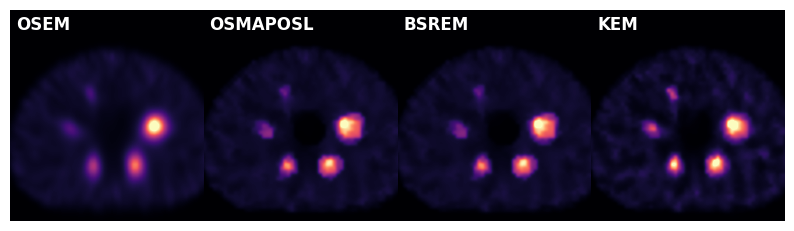

In [13]:
fig, ax = plt.subplots(1,4,figsize=(10,3), gridspec_kw={'wspace':0.0})
for i in range(4):
    plt.sca(ax[i])
    plt.imshow(recons[i][:,:,IDX_AXIAL].cpu().T , cmap='magma', interpolation='gaussian', origin='lower', vmax=20)
    plt.text(0.03, 0.97, recon_names[i], color='white', fontsize=12, fontweight='bold', transform=plt.gca().transAxes, ha='left', va='top')
    plt.xlim(35,90)
    plt.ylim(95,35)
    plt.axis('off')
plt.show()